### Clustering & Retrieval of Wikipedia Documents 

When exploring a large set of documents -- such as Wikipedia, news articles, StackOverflow, etc. -- it can be useful to get a list of related material. Using the People Wikipedia data, you can find out nearest neighbors for various people based on their wikipedia information. To find relevant documents you typically decide on a notion of similarity and find the documents that are most similar. When properly executed, clustering uncovers valuable insights from a set of unlabeled documents. This notebook covers the following clustering algorithms:

* Mixture Models
* Latent Dirichlet Allocation (LDA)

In the notebook you will:
* Apply standard preprocessing techniques on Wikipedia text data
* Using clustering methods to group Wikipedia documents
* Gain intuition for different notions of similarity and practice finding similar documents. 
* Evaluate cluster performance
* Explore and interpret the results, including topic keywords and topic assignments for documents

In [1]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
import pandas as pd

## Import People Wikipedia Dataset

In [2]:
wiki = pd.read_csv('../datasets/people_wiki.csv')

In [3]:
wiki

,URI,name,text
0,<http://dbpedia.org/resource/Digby_Morrell>,Digby Morrell,digby morrell born 10 october 1979 is a former...
1,<http://dbpedia.org/resource/Alfred_J._Lewy>,Alfred J. Lewy,alfred j lewy aka sandy lewy graduated from un...
2,<http://dbpedia.org/resource/Harpdog_Brown>,Harpdog Brown,harpdog brown is a singer and harmonica player...
3,<http://dbpedia.org/resource/Franz_Rottensteiner>,Franz Rottensteiner,franz rottensteiner born in waidmannsfeld lowe...
4,<http://dbpedia.org/resource/G-Enka>,G-Enka,henry krvits born 30 december 1974 in tallinn ...
...,...,...,...
42781,<http://dbpedia.org/resource/Motoaki_Takenouchi>,Motoaki Takenouchi,motoaki takenouchi born july 8 1967 saitama pr...
42782,<http://dbpedia.org/resource/Alan_Judge_(footb...,"Alan Judge (footballer, born 1960)",alan graham judge born 14 may 1960 is a retire...
42783,<http://dbpedia.org/resource/Eduardo_Lara>,Eduardo Lara,eduardo lara lozano born 4 september 1959 in c...
42784,<http://dbpedia.org/resource/Tatiana_Faberg%C3...,Tatiana Faberg%C3%A9,tatiana faberg is an author and faberg scholar...


In [4]:
top_n=3
missing_column_counts = wiki[wiki.columns[wiki.isnull().any()]].isnull().sum()
max_idxs = np.argsort(missing_column_counts.to_numpy())[::-1][:top_n]

# Compute missing statistics
num_categories = wiki.isna().any(axis=0).sum()
average_per_category = wiki.isna().sum().sum()/len(wiki.columns)
top_missing_categories = wiki.columns[max_idxs[:top_n]].to_numpy()

print('Number of categories: {}'.format(num_categories))
print('Average missing values per categories: {}'.format(average_per_category))
print('Categories with top {} missing values: {}'.format(top_n,top_missing_categories))

Number of categories: 0
Average missing values per categories: 0.0
Categories with top 3 missing values: []


In [5]:
print('There are {} articles in the Wikipedia dataset'.format(len(wiki)))
wiki = wiki[:1000] # explore first 1000 articles

There are 42786 articles in the Wikipedia dataset


In [6]:
print(wiki['text'][269])

kerr cuhulain is the pen name of canadian occult author and retired detective constable charles ennis a former child abuse investigator he is the author of several articles on child abuse investigation that appeared in law order magazine a former air force officer cuhulain was a police officer for over 28 years a police dispatcher for another 8 years and a wiccan for over forty hes served on the swat team gang crime unit and hostage negotiation teambetter known to the pagan community by his wiccan name kerr cuhulain ennis was the first wiccan police officer to go public about his beliefs 36 years ago he is the former preceptor general of officers of avalon a nonprofit benevolent association for pagan and wiccan law enforcement firefighting and emergency medical personnel and their families he is a frequent contributor to the witches voice networking website and has applied his abilities as an investigative journalist to the histories of several controversial individuals in the neopagan

## Explore Wikipedia dataset

### Descriptive Statistics
- total_num_words: Total number of words
- average_word_count: Average word count per articles
- top_n_articles_most_words: Top n articles with most words
- top_n_articles_least_words: Top n articles with and least words

In [7]:
# Drop Nans
num_obs=len(wiki)
wiki = wiki.dropna()
print('{} articles have been removed from the dataset'.format(num_obs-len(wiki)))

0 articles have been removed from the dataset


In [8]:
wiki.isna().sum()

URI     0
name    0
text    0
dtype: int64

In [9]:
top_n=3
wiki['num_words'] = wiki['text'].apply(lambda sentence: len(sentence.split()))
total_num_words = wiki['num_words'].sum()
average_word_count = total_num_words / len(wiki)
top_n_reviews_most_words = wiki.nlargest(top_n, 'num_words')['text']
top_n_names_most_words = wiki.nlargest(top_n, 'num_words')['name']

top_n_reviews_least_words = wiki.nsmallest(top_n, 'num_words')['text']
top_n_names_least_words = wiki.nsmallest(top_n, 'num_words')['name']

In [10]:
print('Total number of words: {}'.format(total_num_words))
print('Average words per article: {}'.format(average_word_count))
print('Top {} articles with most words: {}'.format(top_n, [i for i in top_n_names_most_words]))
print('Top {} articles with least words: {}'.format(top_n, [i for i in top_n_names_least_words]))

Total number of words: 312223
Average words per article: 312.223
Top 3 articles with most words: ['John Donald (jewellery designer)', 'Davi Kopenawa Yanomami', 'Mary Fitzgerald (artist)']
Top 3 articles with least words: ['G-Enka', 'Albert Apuzzi', 'Se%C3%A1n %C3%93g %C3%93 hAilp%C3%ADn']


### Remove unuseful articles

In [11]:
keyword = 'Se%C3%A1n %C3%93g %C3%93 hAilp%C3%ADn'
print('One example of an useful article: {}'.format([i for i in wiki[wiki['name']==keyword]['text']]))

One example of an useful article: ['sen g hailpn born 22 may 1977 is a fijianirish hurler and gaelic footballerin an intercounty playing career that spanned three decades hailpn played for the cork senior hurling and football teams winning major honours with both he also enjoyed much success with club side na piarsaigh and represented munster in the interprovincial championshipsafter starting his career as a hurler at minor level hailpn joined the cork senior hurling team in 1996 between then and 2012 he won three allireland medals five munster medals and one national hurling league medal hailpns threeyear career with the cork senior football team saw him win one munster medal and one national football league medalat club level hailpn is a twotime county hurling championship medalist with na piarsaigh hailpn has a number of personal achievements including three consecutive all star awards in 2004 he made a clean sweep of all the top individual awards winning the alln star texaco and gp

In [12]:
index_drop = wiki[(wiki['name'] >= keyword)].index
wiki.drop(index_drop)# , inplace=True)
wiki.reset_index()

,index,URI,name,text,num_words
0,0,<http://dbpedia.org/resource/Digby_Morrell>,Digby Morrell,digby morrell born 10 october 1979 is a former...,251
1,1,<http://dbpedia.org/resource/Alfred_J._Lewy>,Alfred J. Lewy,alfred j lewy aka sandy lewy graduated from un...,223
2,2,<http://dbpedia.org/resource/Harpdog_Brown>,Harpdog Brown,harpdog brown is a singer and harmonica player...,226
3,3,<http://dbpedia.org/resource/Franz_Rottensteiner>,Franz Rottensteiner,franz rottensteiner born in waidmannsfeld lowe...,377
4,4,<http://dbpedia.org/resource/G-Enka>,G-Enka,henry krvits born 30 december 1974 in tallinn ...,201
...,...,...,...,...,...
995,995,<http://dbpedia.org/resource/Tantely_Andrianar...,Tantely Andrianarivo,ren tantely gabrio andrianarivo born 25 may 19...,508
996,996,<http://dbpedia.org/resource/Terry_Wogan>,Terry Wogan,sir michael terence terry wogan kbe dl born 3 ...,233
997,997,<http://dbpedia.org/resource/Mike_LaValliere>,Mike LaValliere,michael eugene mike lavalliere born august 18 ...,353
998,998,<http://dbpedia.org/resource/Benjamin_Vogt_(po...,Benjamin Vogt (poet),benjamin vogt is a poet and essayist from linc...,374


In [13]:
index_drop = wiki[(wiki['name'] >= keyword)].index
print('This array should be empty to show the keyword item was removed: {}'.format(index_drop))

This array should be empty to show the keyword item was removed: Int64Index([  7,  10,  24,  25,  31,  36,  38,  40,  42,  46,
            ...
            952, 955, 965, 966, 967, 970, 974, 987, 995, 996],
           dtype='int64', length=139)


### Inspect articles with keyword search

In [14]:
# Search by article name
keyword = 'Digby Morrell'
digby_morrell_text = wiki.loc[wiki['name']==keyword, 'text'].tolist()

print('Number of words in {} article is {}\n'.format(keyword,len(digby_morrell_text[0])))
print('{} article: {}'.format(keyword,digby_morrell_text))

Number of words in Digby Morrell article is 1479

Digby Morrell article: ['digby morrell born 10 october 1979 is a former australian rules footballer who played with the kangaroos and carlton in the australian football league aflfrom western australia morrell played his early senior football for west perth his 44game senior career for the falcons spanned 19982000 and he was the clubs leading goalkicker in 2000 at the age of 21 morrell was recruited to the australian football league by the kangaroos football club with its third round selection in the 2001 afl rookie draft as a forward he twice kicked five goals during his time with the kangaroos the first was in a losing cause against sydney in 2002 and the other the following season in a drawn game against brisbaneafter the 2003 season morrell was traded along with david teague to the carlton football club in exchange for corey mckernan he played 32 games for the blues before being delisted at the end of 2005 he continued to play victo

### Inspect article word counts with keyword search

In [15]:
from sklearn.feature_extraction.text import CountVectorizer

keyword = 'Digby Morrell'
keyword_text = wiki.loc[wiki['name']==keyword, 'text'].tolist()

counter = CountVectorizer(stop_words='english')
count_matrix =counter.fit_transform(keyword_text)
features = counter.get_feature_names()

# Create a series from the sparse matrix
digby_counter = pd.Series(count_matrix.toarray().flatten(), 
              index = features).sort_values(ascending=False)

### Plot the most 50 frequent words in keyword in the article name without taking under consideration  the stopwords.

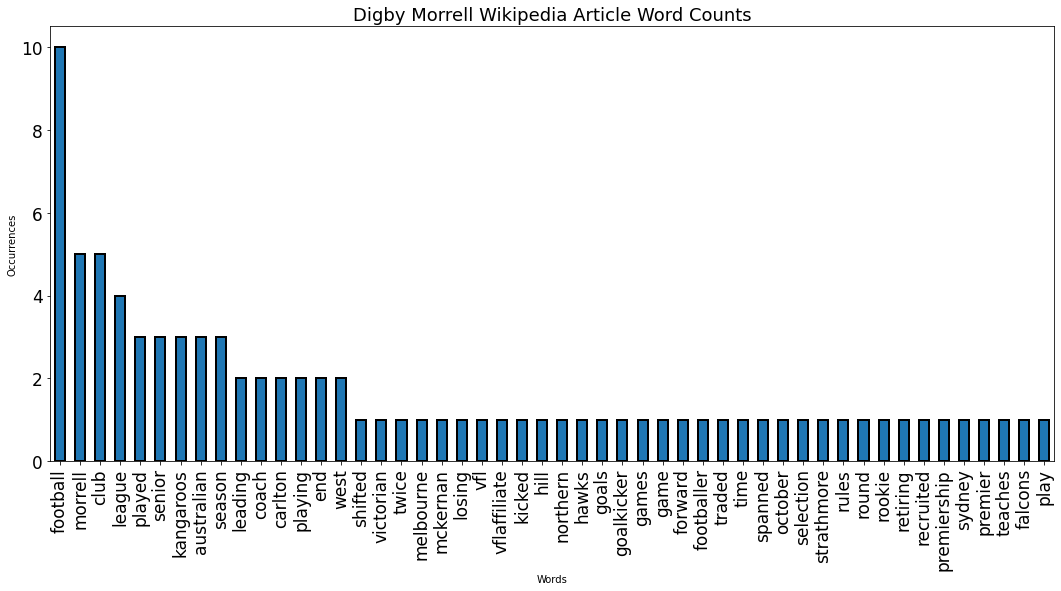

In [16]:
bar_graph = digby_counter[:50].plot(kind='bar', 
                                        figsize=(18,8), 
                                        alpha=1, 
                                        fontsize=17, 
                                        rot=90,
                                        edgecolor='black', 
                                        linewidth=2,
                                        title=keyword+' Wikipedia Article Word Counts')
bar_graph.set_xlabel('Words')
bar_graph.set_ylabel('Occurrences')
bar_graph.title.set_size(18)

### Inspect article TF-IDF with keyword search

In [17]:
from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer

def plot_tf_idf_keyword(name, wiki):
    #Apply this vectorizer to the full dataset to create normalized vectors
    tfidf_vectorizer = TfidfVectorizer(min_df=5, max_df = 0.8, sublinear_tf=True, use_idf =True, stop_words = 'english')

    #tfidf_vectorizer.fit: Learn vocabulary and idf from training set.
    tfidf_matrix = tfidf_vectorizer.fit_transform(wiki.text.values)

    #tfidf_vectorizer.get_feature_names(): Array mapping from feature integer indices to feature name
    features = tfidf_vectorizer.get_feature_names()

    #Get the row that belongs to name
    row = wiki[wiki.name==name].index.tolist()[0]

    #Create a series from the sparse matrix
    clinton_matrix = pd.Series(tfidf_matrix.getrow(row).toarray().flatten(),index = features).sort_values(ascending=False)
    tf_idf_plot = clinton_matrix[:20].plot(kind='bar', title= name+' Wikipedia Article Word TF-IDF Values',
                figsize=(10,6), alpha=1, fontsize=14, rot=80,edgecolor='black', linewidth=2 )
    tf_idf_plot.title.set_size(18)
    tf_idf_plot.set_xlabel('WORDS')
    tf_idf_plot.set_ylabel('TF-IDF')

In [18]:
# Clusters y --> document name
print(wiki['name'])

0             Digby Morrell
1            Alfred J. Lewy
2             Harpdog Brown
3       Franz Rottensteiner
4                    G-Enka
               ...         
995    Tantely Andrianarivo
996             Terry Wogan
997         Mike LaValliere
998    Benjamin Vogt (poet)
999             Neil Fallon
Name: name, Length: 1000, dtype: object


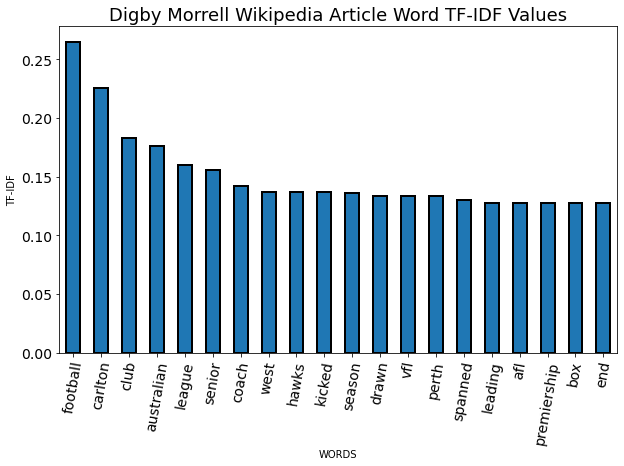

In [19]:
name = 'Digby Morrell'
#name = 'Mike LaValliere'
wiki_copy = wiki.copy()
plot_tf_idf_keyword(name, wiki_copy)

## Extract word count vectors

As we have seen in the 'Predicting Product sentiment' notebook.

In [20]:
import string 
def remove_punctuation(text):
    try: # python 2.x
        text = text.translate(None, string.punctuation) 
    except: # python 3.x
        translator = text.maketrans('', '', string.punctuation)
        text = text.translate(translator)
    return text

In [21]:
wiki['text'] = wiki['text'].apply(remove_punctuation)
print(wiki['text'])

0      digby morrell born 10 october 1979 is a former...
1      alfred j lewy aka sandy lewy graduated from un...
2      harpdog brown is a singer and harmonica player...
3      franz rottensteiner born in waidmannsfeld lowe...
4      henry krvits born 30 december 1974 in tallinn ...
                             ...                        
995    ren tantely gabrio andrianarivo born 25 may 19...
996    sir michael terence terry wogan kbe dl born 3 ...
997    michael eugene mike lavalliere born august 18 ...
998    benjamin vogt is a poet and essayist from linc...
999    neil patrick fallon october 25 1971 in portsmo...
Name: text, Length: 1000, dtype: object


In [22]:
# Word Count
from sklearn.feature_extraction.text import CountVectorizer
count_vect = CountVectorizer(analyzer='word',       
                            min_df=10,                        # minimum reqd occurences of a word 
                            stop_words='english',             # remove stop words
                            lowercase=True,                   # convert all words to lowercase
                            token_pattern='[a-zA-Z0-9]{3,}',  # num chars > 3
                            max_features=50000)             # max number of uniq words

X_train_counts = count_vect.fit_transform(wiki['text'])

word_count_df = pd.DataFrame(X_train_counts.toarray())
word_count_df = word_count_df.add_prefix('word_count_')
wiki = pd.concat([wiki, word_count_df], axis=1)

In [23]:
# Materialize the sparse data
data_dense = X_train_counts.todense()

# Compute Sparsicity = Percentage of Non-Zero cells
print("Sparsicity: ", ((data_dense > 0).sum()/data_dense.size)*100, "%")

Sparsicity:  3.3256442227763925 %


In [24]:
# TF-IDF
from nltk.tokenize import RegexpTokenizer

# Initialize regex tokenizer
tokenizer = RegexpTokenizer(r'\w+')

# Vectorize document using TF-IDF
vectorizer = TfidfVectorizer(lowercase=True,
                        stop_words='english',
                        ngram_range = (1,1),
                        tokenizer = tokenizer.tokenize)

X_train_tfidf = vectorizer.fit_transform(wiki['text'])

tf_idf_word_count_df = pd.DataFrame(X_train_tfidf.toarray())
tf_idf_word_count_df = tf_idf_word_count_df.add_prefix('tf_idf_word_count_')
wiki = pd.concat([wiki, tf_idf_word_count_df], axis=1)

# Build vocabulary of words
word_vocabulary = vectorizer.get_feature_names()
print(wiki.head())

                                                 URI                 name  \
0        <http://dbpedia.org/resource/Digby_Morrell>        Digby Morrell   
1       <http://dbpedia.org/resource/Alfred_J._Lewy>       Alfred J. Lewy   
2        <http://dbpedia.org/resource/Harpdog_Brown>        Harpdog Brown   
3  <http://dbpedia.org/resource/Franz_Rottensteiner>  Franz Rottensteiner   
4               <http://dbpedia.org/resource/G-Enka>               G-Enka   

                                                text  num_words  word_count_0  \
0  digby morrell born 10 october 1979 is a former...        251             0   
1  alfred j lewy aka sandy lewy graduated from un...        223             0   
2  harpdog brown is a singer and harmonica player...        226             0   
3  franz rottensteiner born in waidmannsfeld lowe...        377             0   
4  henry krvits born 30 december 1974 in tallinn ...        201             0   

   word_count_1  word_count_2  word_count_3  word_

## Split data into training and test sets

Let's perform a train/test split with 80% of the data in the training set and 20% of the data in the test set. We use seed=1 so that everyone gets the same result.

In [25]:
from sklearn.model_selection import train_test_split

X_word_count = wiki.loc[:, wiki.columns.str.startswith('word_count_')] # Use word count
print(len(X_word_count))
print(X_word_count.head())

1000
   word_count_0  word_count_1  word_count_2  word_count_3  word_count_4  \
0             0             0             0             0             0   
1             0             0             0             0             0   
2             0             0             0             0             0   
3             0             0             0             0             0   
4             0             0             0             0             0   

   word_count_5  word_count_6  word_count_7  word_count_8  word_count_9  ...  \
0             0             0             0             0             0  ...   
1             0             0             0             0             0  ...   
2             0             0             0             0             0  ...   
3             0             0             0             0             1  ...   
4             0             0             0             0             0  ...   

   word_count_2396  word_count_2397  word_count_2398  word_coun

In [26]:
# TF-IDF encode words form documents
X_tfidf = wiki.loc[:, wiki.columns.str.startswith('tf_idf_word_count_')] # Use tf-idf
print('TF-IDF encoded features: {}'.format(X_tfidf.head()))

# Integer Encode cluster names
from sklearn.preprocessing import OrdinalEncoder

ord_enc = OrdinalEncoder()
wiki['y'] = ord_enc.fit_transform(wiki[["name"]])
y = wiki['y']
print('Integer encoded cluster names'.format(wiki[["name", 'y']].head(11)))

TF-IDF encoded features:    tf_idf_word_count_0  tf_idf_word_count_1  tf_idf_word_count_2  \
0                  0.0                  0.0                  0.0   
1                  0.0                  0.0                  0.0   
2                  0.0                  0.0                  0.0   
3                  0.0                  0.0                  0.0   
4                  0.0                  0.0                  0.0   

   tf_idf_word_count_3  tf_idf_word_count_4  tf_idf_word_count_5  \
0                  0.0                  0.0                  0.0   
1                  0.0                  0.0                  0.0   
2                  0.0                  0.0                  0.0   
3                  0.0                  0.0                  0.0   
4                  0.0                  0.0                  0.0   

   tf_idf_word_count_6  tf_idf_word_count_7  tf_idf_word_count_8  \
0                  0.0                  0.0                  0.0   
1                  0.

# Gaussian mixture models

We have explored k-means clustering for a high-dimensional Wikipedia dataset. We can also model this data with a mixture of Gaussians, though with increasing dimension we run into two important issues associated with using a full covariance matrix for each component.

Both of these issues are avoided if we require the covariance matrix of each component to be diagonal, as then it has only M parameters to fit and the score computation decomposes into M univariate score calculations. Recall from the lecture that the M-step for the full covariance is:

\begin{align*}
\hat{\Sigma}_k &= \frac{1}{N_k^{soft}} \sum_{i=1}^N r_{ik} (x_i-\hat{\mu}_k)(x_i - \hat{\mu}_k)^T
\end{align*}

Note that this is a square matrix with M rows and M columns, and the above equation implies that the (v, w) element is computed by

\begin{align*}
\hat{\Sigma}_{k, v, w} &= \frac{1}{N_k^{soft}} \sum_{i=1}^N r_{ik} (x_{iv}-\hat{\mu}_{kv})(x_{iw} - \hat{\mu}_{kw})
\end{align*}

When we assume that this is a diagonal matrix, then non-diagonal elements are assumed to be zero and we only need to compute each of the M elements along the diagonal independently using the following equation. 

\begin{align*}
\hat{\sigma}^2_{k, v} &= \hat{\Sigma}_{k, v, v}  \\
&= \frac{1}{N_k^{soft}} \sum_{i=1}^N r_{ik} (x_{iv}-\hat{\mu}_{kv})^2
\end{align*}

In this section, we will use an EM implementation to fit a Gaussian mixture model with **diagonal** covariances to a subset of the Wikipedia dataset. The implementation uses the above equation to compute each variance term. 

We'll begin by importing the dataset and coming up with a useful representation for each article. After running our algorithm on the data, we will explore the output to see whether we can give a meaningful interpretation to the fitted parameters in our model.

This section on Mixture Models covers:
 * Computational cost becomes prohibitive in high dimensions: score calculations have complexity cubic in the number of dimensions M if the Gaussian has a full covariance matrix.
 * A model with many parameters require more data: observe that a full covariance matrix for an M-dimensional Gaussian will have M(M+1)/2 parameters to fit. With the number of parameters growing roughly as the square of the dimension, it may quickly become impossible to find a sufficient amount of data to make good inferences.

Mixture Model Parameters
* n_components (int): The number of mixture components; default=1
* covariance_type: String describing the type of covariance parameters to use; default=’full’
     - ‘full’: each component has its own general covariance matrix.
     - ‘tied’: all components share the same general covariance matrix.
     - ‘diag’: each component has its own diagonal covariance matrix.
     - ‘spherical’: each component has its own single variance.
* tol (float):  convergence threshold. EM iterations will stop when the lower bound average gain is below this threshold; default=1e-3
* reg_covar (float): Non-negative regularization added to the diagonal of covariance. Allows to assure that the covariance matrices are all positive; default=1e-6
* max_iterint: The number of EM iterations to perform; default=100
* n_init (int): number of initializations to perform. The best results are kept; default=1
* init_params: The method used to initialize the weights, the means and the precisions. default=’kmeans’. String must be one of:
     - ‘kmeans’ : responsibilities are initialized using kmeans.
     - ‘k-means++’ : use the k-means++ method to initialize.
     - ‘random’ : responsibilities are initialized randomly.
     - ‘random_from_data’ : initial means are randomly selected data points.
* random_state (int): controls the random seed given to the method chosen to initialize the parameters; default=None

In [27]:
# Set parameters
n_components=6
random_state=42
num_obs=10 #len(X_tfidf)

Train mixture model

In [28]:
from sklearn.mixture import GaussianMixture

gmm = GaussianMixture(n_components=n_components, 
                      random_state=random_state, 
                      covariance_type='diag').fit(X_tfidf[:num_obs])

In [29]:
print(gmm.means_)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


Assign every data point to one of the clusters using gmm.predict

In [30]:
gmm_clusters = gmm.predict(X_tfidf[:num_obs])
gmm_clusters

array([2, 3, 1, 1, 0, 4, 0, 1, 0, 5])

Find probabilities that a data point belongs to each of the K clusters

In [31]:
gmm_prob = gmm.predict_proba(X_tfidf[:num_obs])
gmm_prob

array([[0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1.]])

Find GMM covariances

In [32]:
gmm_covariances = gmm.covariances_
gmm_covariances

array([[1.e-06, 1.e-06, 1.e-06, ..., 1.e-06, 1.e-06, 1.e-06],
       [1.e-06, 1.e-06, 1.e-06, ..., 1.e-06, 1.e-06, 1.e-06],
       [1.e-06, 1.e-06, 1.e-06, ..., 1.e-06, 1.e-06, 1.e-06],
       [1.e-06, 1.e-06, 1.e-06, ..., 1.e-06, 1.e-06, 1.e-06],
       [1.e-06, 1.e-06, 1.e-06, ..., 1.e-06, 1.e-06, 1.e-06],
       [1.e-06, 1.e-06, 1.e-06, ..., 1.e-06, 1.e-06, 1.e-06]])

# Evaluating GMMs

The best way to find an best cluster number is to try different cluster numbers and see which fits your data appropriately. The two most popular evaluation metrics for picking cluster numbers for fitting Gaussian Mixture models are Akaike information criterion (AIC) and Bayesian information criterion (BIC).  The intuition in the calculation of both of these metrics is that they favor the simplest model that maximize the likelihood function of the model.

In [33]:
# Impact of covariance
def compute_GaussianMixture(X, n_components, max_iter=100):
    covariance_types = ['diag','spherical'] #removing 'tied' and 'full' --> lon runtime
    models = [None for n in covariance_types]
    for i, covariance_type in enumerate(covariance_types):
        models[i] = GaussianMixture(n_components=n_components, max_iter=max_iter,
                                    covariance_type=covariance_type)
        models[i].fit(X)
    return models

models = compute_GaussianMixture(X_tfidf, 13)

AIC = [m.aic(X_tfidf) for m in models]
BIC = [m.bic(X_tfidf) for m in models]

i_best = np.argmin(AIC)
gmm_best = models[i_best]
print("best fit converged:", gmm_best.converged_)

i_best = np.argmin(BIC)
gmm_best = models[i_best]
print("best fit converged:", gmm_best.converged_)

best fit converged: True
best fit converged: True


# Find the best GMM 

Use scoring systems for model comparisons in statistics dealing with models with different numbers of parameters.

Akaike information criterion (AIC): Akaike information criterion for the current model on the input X. (lower is better) 


In [34]:
gmm.aic(X_tfidf[:num_obs])

-3233075.4476941824

Bayesian information criterion (BIC): Bayesian information criterion for the current model on the input X. (lower is better) 


In [35]:
gmm.bic(X_tfidf[:num_obs])

-3109742.6715450883

Calculate the AIC and BIC is by setting up a loop to try different cluster numbers and calculate the AIC and BIC, you can then plot the metrics together to pick the cluster number.

In [36]:
N = np.arange(1, 14)

def compute_GaussianMixture(X, N, covariance_type='diag', max_iter=100):
    models = [None for n in N]
    for i in range(len(N)):
        models[i] = GaussianMixture(n_components=N[i], max_iter=max_iter,
                                    covariance_type=covariance_type)
        models[i].fit(X)
    return models

models = compute_GaussianMixture(X_tfidf, N)

AIC = [m.aic(X_tfidf) for m in models]
BIC = [m.bic(X_tfidf) for m in models]

i_best = np.argmin(AIC)
gmm_best = models[i_best]
print("best fit converged:", gmm_best.converged_)
print("AIC: n_components =  %i" % N[i_best])

i_best = np.argmin(BIC)
gmm_best = models[i_best]
print("best fit converged:", gmm_best.converged_)
print("BIC: n_components =  %i" % N[i_best])

best fit converged: True
AIC: n_components =  13
best fit converged: True
BIC: n_components =  13


Text(0.5, 1.0, 'BIC and AIC Scores Per Number Of Clusters')

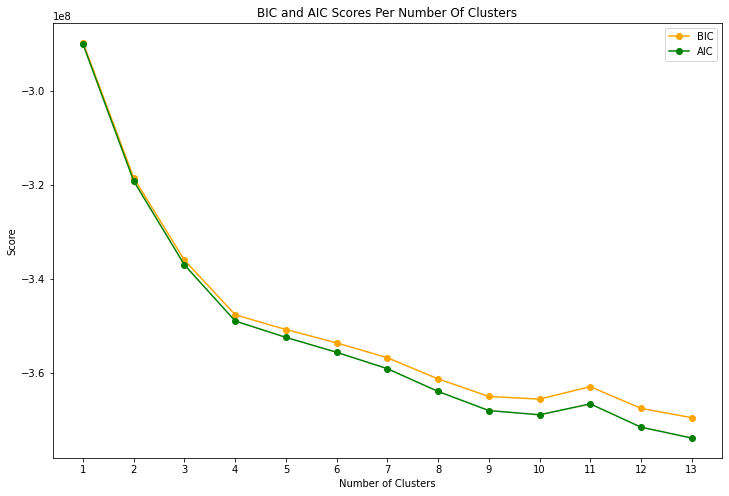

In [37]:
# Plot the BIC and AIC values together
fig, ax = plt.subplots(figsize=(12,8),nrows=1)
ax.plot(N, BIC, '-o', color='blue', label='BIC')
ax.plot(N, AIC, '-o', color='green', label='AIC')
ax.set(xlabel='Number of Clusters', ylabel='Score')
ax.set_xticks(N)
ax.legend()
ax.set_title('BIC and AIC Scores Per Number Of Clusters')

We can see that AIC and BIC are similar but at 13 clusters, BIC > AIC at 13 clusters.The two measures will usually pick the same number for clusters, but if they differ then know that BIC more heavily favors simple models than AIC. AIC models tend the fit the data a better. In this example, I would pick 6 as the most appropriate cluster number for the data as the chart really levels off after that.

**After class Activities**
* Use 'diag','spherical' 'tied' and 'full' covariance martices and determine the best covariance_type on X_tfidf

# Latent Dirichlet Allocation for Text Data


We will use Sklearn and numpy libraries to fit an LDA model to a corpus of Wikipedia articles and examine the results to analyze the impact of a mixed membership approach. In particular, we want to identify the topics discovered by the model in terms of their most important words, and we want to use the model to predict the topic membership distribution for a given document. 

# LDA Parameters

* n_components (int): Number of topics. default=10
* doc_topic_prior (float) Prior of document topic distribution alpha. If the value is None, defaults to 1 / n_components (alsp called alpha). default=None
* topic_word_prior (float): Prior of topic word distribution beta. If the value is None, defaults to 1 / n_components. This is often called eta. default=None

* learning_method: Method used to update _component. Only used in fit method. In general, if the data size is large, the online update will be much faster than the batch update. default=’batch’
    - 'batch': Batch variational Bayes method. Use all training data in each EM update.
    - 'online': Online variational Bayes method. In each EM update, use mini-batch of training data to update the ``components_`` variable incrementally. The learning rate is controlled by the ``learning_decay`` and the ``learning_offset`` parameters.
    - max_iter (int): The maximum number of passes over the training data (aka epochs). It only impacts the behavior in the fit method, and not the partial_fit method. default=10
    - batch_size (int): Number of documents to use in each EM iteration. Only used in online learning. default=128

In [55]:
n_components=5
learning_method = 'online'
random_state=42
max_iter=10               # Max learning iterations
batch_size=128            # n docs in each learning iter
evaluate_every = -1       # compute perplexity every n iters
n_jobs = -1               # Use all available CPUs

Train LDA

In [56]:
from sklearn.decomposition import LatentDirichletAllocation

lda_model = LatentDirichletAllocation(n_components=n_components,
                                learning_method=learning_method,
                                random_state=random_state,
                                max_iter=max_iter,          
                                batch_size=batch_size,         
                                evaluate_every = evaluate_every, 
                                n_jobs = n_jobs)              

lda_model.fit(X_tfidf)

LatentDirichletAllocation(learning_method='online', n_components=5, n_jobs=-1,
                          random_state=42)

In [57]:
# Print topics for some given samples:
lda_model.transform(X_tfidf[:10])

array([[0.91029867, 0.02242516, 0.02242576, 0.0224252 , 0.02242521],
       [0.91770504, 0.02057441, 0.02057349, 0.02057352, 0.02057354],
       [0.91336026, 0.02165985, 0.02165979, 0.02166032, 0.02165978],
       [0.93586926, 0.0160327 , 0.01603272, 0.01603264, 0.01603268],
       [0.89797581, 0.02550517, 0.0255056 , 0.02550547, 0.02550794],
       [0.92402796, 0.01899364, 0.01899286, 0.01899277, 0.01899277],
       [0.9301648 , 0.01745867, 0.01745885, 0.01745888, 0.0174588 ],
       [0.94462936, 0.01384256, 0.01384256, 0.01384293, 0.01384259],
       [0.92849359, 0.0178774 , 0.01787629, 0.01787639, 0.01787632],
       [0.91299108, 0.02175285, 0.02175204, 0.02175205, 0.02175198]])

In [58]:
# Print all components (topics)
lda_components=lda_model.components_
lda_components

array([[0.37092307, 0.26077253, 0.26056486, ..., 0.2956993 , 0.29666738,
        0.78674065],
       [0.20120533, 0.20120913, 0.20141807, ..., 0.20130814, 0.20135926,
        0.20161075],
       [0.20164711, 0.20130726, 0.20098524, ..., 0.20151827, 0.20096899,
        0.20141387],
       [0.20138735, 0.20107438, 0.20143553, ..., 0.20124625, 0.20119732,
        0.20131524],
       [0.20161435, 0.20118716, 0.2012062 , ..., 0.2013076 , 0.20121611,
        0.20145483]])

The compnents represent the number of times word j was assigned to topic i for each document

# Evaluate LDA 

One of the shortcomings of topic modeling is that there’s no guidance on the quality of topics produced. If you want to know how meaningful the topics are, you’ll need to evaluate the topic model.

* Human judgment
  * Observation-based, eg. observing the top ‘n‘ words in a topic
  * Interpretation-based, identify the words or topics that “don’t belong” in a topic or document
* Quantitative metrics – Perplexity (held out likelihood) and coherence calculations
* Mixed approaches – Combinations of judgment-based and quantitative approaches

Method 1: Use human judgement to determine how easy it is to interpret the topics produced by the model.

In [59]:
# Human Judgement
terms = features
for index, component in enumerate(lda_components):
    zipped = zip(terms, component)
    top_terms_key=sorted(zipped, key = lambda t: t[1], reverse=True)[:7]
    top_terms_list=list(dict(top_terms_key).keys())
    print("Topic "+str(index)+": ",top_terms_list)

Topic 0:  ['acted', 'afl', 'perth', 'aflfrom', 'assistant', 'age', 'australia']
Topic 1:  ['afl', 'perth', 'playing', 'acted', 'digby', 'game', 'carltons']
Topic 2:  ['acted', 'afl', 'aflfrom', 'perth', 'rules', 'brisbaneafter', '2002']
Topic 3:  ['melbourne', 'played', 'premiership', 'senior', 'brisbaneafter', 'acted', 'continued']
Topic 4:  ['blues', 'senior', '10', 'spanned', 'round', 'currently', 'traded']


Method 2: Use perplexity (held out likelihood) which train a topic model using the training set and then test the model on a test set that contains previously unseen documents (ie. held-out documents). It assesses a topic model’s ability to predict a test set after having been trained on a training set.

In practice, around 80% of a corpus may be set aside as a training set with the remaining 20% being a test set.

In [60]:
# Use first 100 examples
print("Model Perplexity: ", lda_model.perplexity(X_tfidf[:100]))

Model Perplexity:  103290626.57657254


In [44]:
# Use all examples
print("Model Perplexity: ", lda_model.perplexity(X_tfidf))

Model Perplexity:  143735.3822554049


One issue with using model perplexity for topic modeling evaluation is that it's often inconsistent with human judgments. This means that as the perplexity score improves (i.e., the held out log-likelihood is higher), the human interpretability of topics gets worse (rather than better).

# Finding the best LDA model

Use Grid search to find the parameters of the best model

In [45]:
from sklearn.model_selection import GridSearchCV

# Define LDA Parameters
learning_method = 'online'
random_state=42
max_iter=10               # Max learning iterations
batch_size=128            # n docs in each learning iter
evaluate_every = -1       # compute perplexity every n iters, default: Don't
n_jobs = -1               # Use all available CPUs

# Define Search Param
n_components = [10, 15]#, 20, 25, 30]
learning_decay = [.5, .7, .9]
search_params = {'n_components': n_components, 'learning_decay': learning_decay}

In [46]:
# Init the Model
lda_model = LatentDirichletAllocation(n_components=n_components,
                                learning_method=learning_method,
                                random_state=random_state,
                                max_iter=max_iter,          
                                batch_size=batch_size,         
                                evaluate_every = evaluate_every, 
                                n_jobs = n_jobs) 

# Init Grid Search Class
lda_grid_model = GridSearchCV(lda_model, param_grid=search_params)

# Use Grid Search to find the best paramters
lda_grid_model.fit(X_tfidf)

GridSearchCV(estimator=LatentDirichletAllocation(learning_method='online',
                                                 n_components=[10, 15],
                                                 n_jobs=-1, random_state=42),
             param_grid={'learning_decay': [0.5, 0.7, 0.9],
                         'n_components': [10, 15]})

Find the best LDA model

Perplexity as well is one of the intrinsic evaluation metric, and is widely used for language model evaluation. It captures how surprised a model is of new data it has not seen before, and is measured as the normalized log-likelihood of a held-out test set.

In [47]:
best_lda_model = lda_grid_model.best_estimator_

# Model Parameters
print("Best Model's Params: ", lda_grid_model.best_params_)

# Log Likelihood Score
print("Best Log Likelihood Score: ", lda_grid_model.best_score_)

# Perplexity
print("Model Perplexity: ", best_lda_model.perplexity(X_tfidf))

Best Model's Params:  {'learning_decay': 0.7, 'n_components': 10}
Best Log Likelihood Score:  -34946.022505183086
Model Perplexity:  315201.43367601867


In [48]:
# Grid Search result dictionary
lda_grid_model.cv_results_.keys()

dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_learning_decay', 'param_n_components', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score'])

In [49]:
lda_grid_model.cv_results_

{'mean_fit_time': array([23.3196713 , 24.62708225, 23.45653   , 24.9356967 , 23.37214499,
        24.51825356]),
 'std_fit_time': array([0.17133272, 0.30323777, 0.20416956, 0.51256187, 0.32696119,
        0.36919032]),
 'mean_score_time': array([0.67175727, 0.69777627, 0.67746964, 0.69061937, 0.67948284,
        0.69107738]),
 'std_score_time': array([0.01739073, 0.0204164 , 0.01481439, 0.01887979, 0.04092952,
        0.02159899]),
 'param_learning_decay': masked_array(data=[0.5, 0.5, 0.7, 0.7, 0.9, 0.9],
              mask=[False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_n_components': masked_array(data=[10, 15, 10, 15, 10, 15],
              mask=[False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'learning_decay': 0.5, 'n_components': 10},
  {'learning_decay': 0.5, 'n_components': 15},
  {'learning_decay': 0.7, 'n_components': 10},
  {'learning_decay': 0.7, 'n_components':

**After class Activities**
* Find best document-topic density $\alpha$ doc_topic_prior from [0.05, 0.1, 0.5, 1, 5, 10, 50] using grid search
* Find best topic-word density $\beta$ topic_word_prior from [0.01, 0.05, 0.1, 0.5, 1, 5, 10] using grid search

Note: Higher $\alpha$ means the model assumes documents contain more topics from vocabulary and a lower value means documents contain one or a fewer

High $\beta$ means that there are more topics in the document from vocabulary and lower values means the documents have few topics from the vocabularly